# 03 - Train Detectron2

In this notebook we are going to train Detectron2 on small datasets of ~6000 images of Camera and Tripod.

In [1]:
%cd open-images-v5

/mnt/data/object_detection/open-images-v5


In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
from tqdm import tqdm
import os, cv2, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 10.0)

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode

In [3]:
def cv2_imshow(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(), plt.imshow(im), plt.axis('off');

## 1. Register Datasets

Register datasets with codes from the previous notebook.

Note that in notebook 02, we have moved all images in subfolders to `images/`.

In [4]:
def denormalize_bboxes(bboxes, height, width):
    """Denormalize bounding boxes in format of (xmin, ymin, xmax, ymax)."""
    bboxes[:, [0, 2]] = bboxes[:, [0, 2]] * width
    bboxes[:, [1, 3]] = bboxes[:, [1, 3]] * height
    return np.round(bboxes)

def get_detectron_dicts(annot_df):
    """
    Create Detectron2's standard dataset from an annotation file.
    
    Args:
        annot_df (pd.DataFrame): annotation dataframe.
    Return:
        dataset_dicts (list[dict]): List of annotation dictionaries for Detectron2.
    """
    # Get image ids
    img_ids = annot_df["ImageID"].unique().tolist()
    
    dataset_dicts = []
    for img_id in tqdm(img_ids):
        file_name = f'images/{img_id}.jpg'
        if not os.path.exists(file_name): continue
        height, width = cv2.imread(file_name).shape[:2]
            
        record = {}
        record['file_name'] = file_name
        record['image_id'] = img_id
        record['height'] = height
        record['width'] = width
        
        # Extract bboxes from annotation file
        bboxes = annot_df[['XMin', 'YMin', 'XMax', 'YMax']][annot_df['ImageID'] == img_id].values
        bboxes = denormalize_bboxes(bboxes, height, width)
        class_ids = annot_df[['ClassID']][annot_df['ImageID'] == img_id].values
        
        annots = []
        for i, bbox in enumerate(bboxes.tolist()):
            annot = {
                "bbox": bbox,
                "bbox_mode": BoxMode.XYXY_ABS,
                "category_id": int(class_ids[i]),
            }
            annots.append(annot)

        record["annotations"] = annots
        dataset_dicts.append(record)
    return dataset_dicts

In [5]:
# Specify target classes and create `class2id` dict
target_classes = ['Camera', 'Tripod']
class2id = {k: v for v, k in enumerate(target_classes)}
print(class2id)

{'Camera': 0, 'Tripod': 1}


In [6]:
# Load target annotations
train_df = pd.read_csv("train-annotations-bbox-truncated.csv")
val_df = pd.read_csv("validation-annotations-bbox-truncated.csv")

# Register dataset with Detectron2
print("Registering Datasets...")
DatasetCatalog.register("camera_tripod_train", lambda d=train_df: get_detectron_dicts(d))
MetadataCatalog.get("camera_tripod_train").set(thing_classes=target_classes)
DatasetCatalog.register("camera_tripod_val", lambda d=val_df: get_detectron_dicts(d))
MetadataCatalog.get("camera_tripod_val").set(thing_classes=target_classes)
print("Done!")

# Get metadata. It helps show class labels when we visualize bounding boxes
camera_tripod_metadata = MetadataCatalog.get("camera_tripod_train")

Registering Datasets...
Done!


## 2. Train

In [7]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

In [8]:
run_name = 'exp-1'
if os.path.exists(run_name):
    !rm -rf $run_name

# Set up model and training configurations
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("camera_tripod_train",)
cfg.DATASETS.TEST = ("camera_tripod_val",)

# Training hyperparameters
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.SOLVER.BASE_LR = 5e-4
cfg.SOLVER.MAX_ITER = 300
cfg.SOLVER.WARMUP_ITERS = 100
cfg.SOLVER.STEPS = (200,)

# Specify class number
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(target_classes)
cfg.MODEL.RETINANET.NUM_CLASSES = len(target_classes) # if using RetinaNet

cfg.DATALOADER.NUM_WORKERS = 6
cfg.OUTPUT_DIR = run_name
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Set up trainer
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[07/14 15:42:06 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

100%|██████████| 6091/6091 [01:41<00:00, 59.82it/s]

[07/14 15:43:48 d2.data.build]: Removed 0 images with no usable annotations. 6091 images left.


[07/14 15:43:48 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|   Camera   | 6404         |   Tripod   | 1446         |
|            |              |            |              |
|   total    | 7850         |            |              |
[07/14 15:43:48 d2.data.common]: Serializing 6091 elements to byte tensors and concatenating them all ...
[07/14 15:43:48 d2.data.common]: Serialized dataset takes 1.57 MiB
[07/14 15:43:48 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[07/14 15:43:48 d2.data.build]: Using training sampler TrainingSampler


Unable to load 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model!
Unable to load 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model!


[07/14 15:43:49 d2.engine.train_loop]: Starting training from iteration 0
[07/14 15:43:55 d2.utils.events]:  eta: 0:01:26  iter: 19  total_loss: 1.440  loss_cls: 0.956  loss_box_reg: 0.518  loss_rpn_cls: 0.016  loss_rpn_loc: 0.013  time: 0.3134  data_time: 0.0256  lr: 0.000095  max_mem: 4959M
[07/14 15:44:01 d2.utils.events]:  eta: 0:01:21  iter: 39  total_loss: 0.922  loss_cls: 0.442  loss_box_reg: 0.458  loss_rpn_cls: 0.015  loss_rpn_loc: 0.010  time: 0.3132  data_time: 0.0097  lr: 0.000195  max_mem: 4959M
[07/14 15:44:08 d2.utils.events]:  eta: 0:01:15  iter: 59  total_loss: 0.853  loss_cls: 0.345  loss_box_reg: 0.474  loss_rpn_cls: 0.012  loss_rpn_loc: 0.010  time: 0.3143  data_time: 0.0102  lr: 0.000295  max_mem: 4959M
[07/14 15:44:14 d2.utils.events]:  eta: 0:01:09  iter: 79  total_loss: 0.724  loss_cls: 0.272  loss_box_reg: 0.464  loss_rpn_cls: 0.011  loss_rpn_loc: 0.007  time: 0.3137  data_time: 0.0095  lr: 0.000395  max_mem: 4959M
[07/14 15:44:20 d2.utils.events]:  eta: 0:01:0

100%|██████████| 166/166 [00:02<00:00, 64.52it/s]

[07/14 15:45:27 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|   Camera   | 153          |   Tripod   | 40           |
|            |              |            |              |
|   total    | 193          |            |              |
[07/14 15:45:27 d2.data.common]: Serializing 166 elements to byte tensors and concatenating them all ...
[07/14 15:45:27 d2.data.common]: Serialized dataset takes 0.04 MiB
WARNING [07/14 15:45:27 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[07/14 15:45:27 d2.utils.events]:  eta: 0:00:00  iter: 299  total_loss: 0.478  loss_cls: 0.158  loss_box_reg: 0.325  loss_rpn_cls: 0.008  loss_rpn_loc: 0.006  time: 0.3154  data_time: 0.0095  lr: 0.000050  max_mem: 4959M
[07/14 15:45:27 d2.engine.hooks]: Overall training speed: 297 iterations in 0:01:33 (0.

That's fast. Training 300 steps only takes 1 min 35s. To view TensorBoard on Colab, run the cell below:

```python
# View TensorBoard:
%load_ext tensorboard
%tensorboard --logdir output
```

## 3. Evaluation

In [9]:
from detectron2.evaluation import COCOEvaluator

evaluator = COCOEvaluator("camera_tripod_val", cfg, False, output_dir=cfg.OUTPUT_DIR)
trainer.test(cfg=cfg,
             model=trainer.model,
             evaluators=evaluator)

WARNING [07/14 15:45:27 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'camera_tripod_val'. Trying to convert it to COCO format ...
[07/14 15:45:27 d2.data.datasets.coco]: Converting annotations of dataset 'camera_tripod_val' to COCO format ...)


100%|██████████| 166/166 [00:02<00:00, 65.06it/s]

[07/14 15:45:29 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[07/14 15:45:29 d2.data.datasets.coco]: Conversion finished, #images: 166, #annotations: 193
[07/14 15:45:29 d2.data.datasets.coco]: Caching COCO format annotations at 'exp-1/camera_tripod_val_coco_format.json' ...



100%|██████████| 166/166 [00:02<00:00, 65.31it/s]

[07/14 15:45:32 d2.data.common]: Serializing 166 elements to byte tensors and concatenating them all ...
[07/14 15:45:32 d2.data.common]: Serialized dataset takes 0.04 MiB
[07/14 15:45:32 d2.evaluation.evaluator]: Start inference on 166 images


[07/14 15:45:32 d2.evaluation.evaluator]: Inference done 11/166. 0.0399 s / img. ETA=0:00:06
[07/14 15:45:37 d2.evaluation.evaluator]: Inference done 136/166. 0.0386 s / img. ETA=0:00:01
[07/14 15:45:39 d2.evaluation.evaluator]: Total inference time: 0:00:06.442064 (0.040013 s / img per device, on 1 devices)
[07/14 15:45:39 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:06 (0.038252 s / img per device, on 1 devices)
[07/14 15:45:39 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[07/14 15:45:39 d2.evaluation.coco_evaluation]: Saving results to exp-1/coco_instances_results.json
[07/14 15:45:39 d2.evaluation.coco_evaluation]: Evaluating predictions ...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.22s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.415
 Average

OrderedDict([('bbox',
              {'AP': 41.47643344526002,
               'AP50': 70.25950629106936,
               'AP75': 38.66556641542805,
               'APs': nan,
               'APm': 37.693069306930695,
               'APl': 42.61129782599682,
               'AP-Camera': 55.735393725928816,
               'AP-Tripod': 27.217473164591215})])

The model achieves 41 mAP after only 300 training steps. That's impressive!

### Inference on the validation set

In [18]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)

In [11]:
dataset_dicts = get_detectron_dicts(val_df)

100%|██████████| 166/166 [00:02<00:00, 64.63it/s]


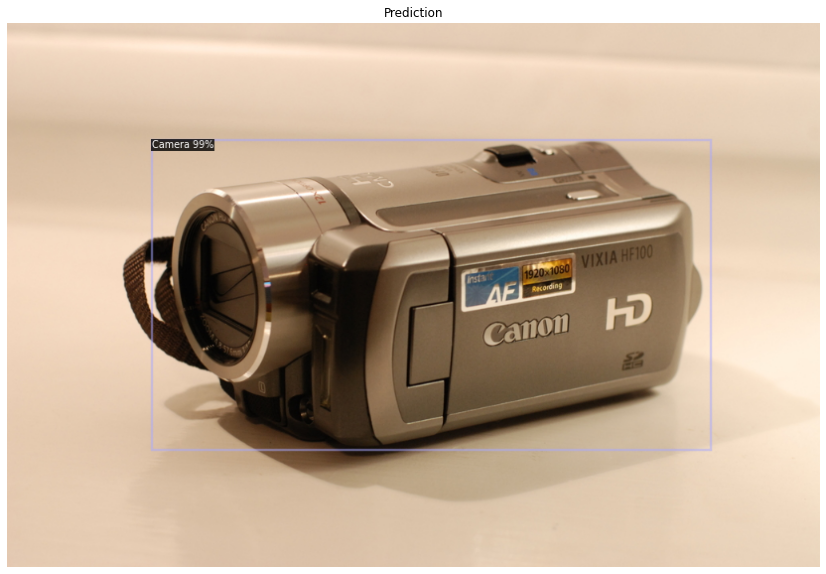

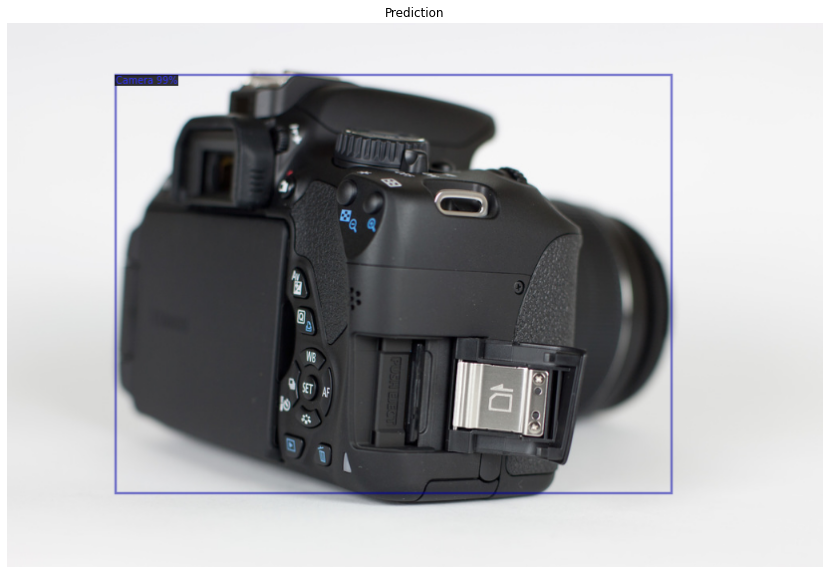

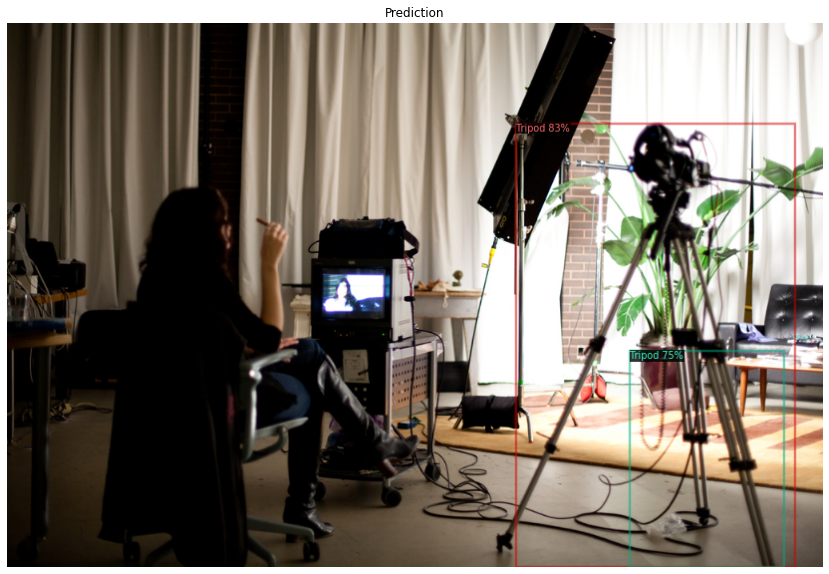

In [19]:
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=camera_tripod_metadata, scale=0.8)
    pred = v.draw_instance_predictions(outputs["instances"][:2].to("cpu"))
    cv2_imshow(pred.get_image()[:, :, ::-1])
    plt.title("Prediction");

Our model is pretty accurate, isn't it?

## 4. Production

After training our model, we should save the configurations to put the model into production.

In [13]:
# Save config
with open(os.path.join(cfg.OUTPUT_DIR, "config.yaml"), "w") as f:
    f.write(cfg.dump())

Now we can load the trained model and run it on images downloaded from the internet.

In [14]:
# Load config
cfg = get_cfg()
cfg.merge_from_file('exp-1/config.yaml')
cfg.MODEL.WEIGHTS = 'exp-1/model_final.pth'

# Set up predictor
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.95
predictor = DefaultPredictor(cfg)

In [15]:
%%capture
# Download an image
!wget -O "./sample.jpg" https://independenttravelcats.com/wp-content/uploads/2017/11/Bakers-beach-VEO-tripod-sunset-san-francisco.jpg

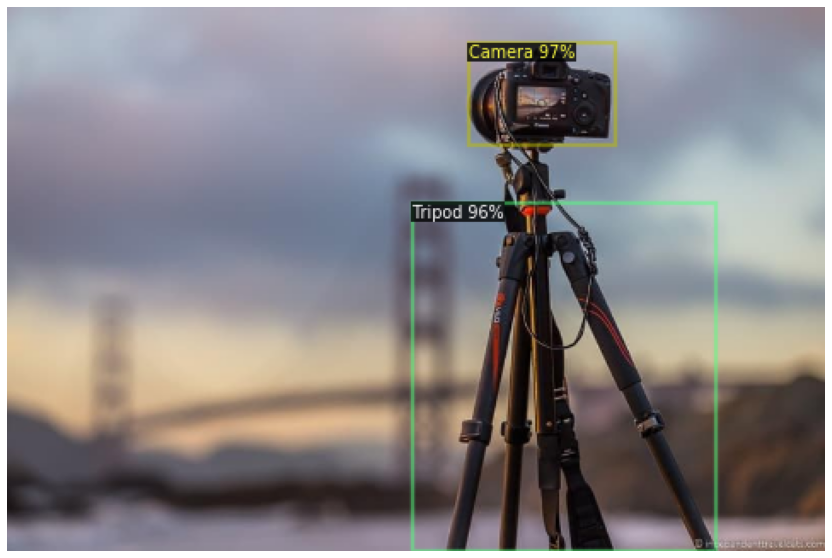

In [16]:
im = cv2.imread("./sample.jpg")
outputs = predictor(im)

# Visualize
v = Visualizer(im[:, :, ::-1], camera_tripod_metadata, scale=0.6)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1]);

Look great! Now we can use Streamlit to deploy our model into a web app. In the next notebook, we will put all steps together and train a complete model to detect musical instruments on a large dataset.